# Загрузка библиотек и открытие файлов.

In [ ]:
!pip install pymorphy3
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import json
from pprint import pprint

import nltk
import re
import pymorphy3    # библиотека для анализа слов на русском языке

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# для открытия и чтения файла с данным c Google.Drive через Google.Colab

from google.colab import drive
drive.mount('/content/drive')
path_DF = '/content/drive/MyDrive/Data_Science/Хакатон_SCAN/Queries.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# В файле Queries.txt приведено множество поисковых запросов клиентов продукта СКАН
# (формат: UserId Query - разделитель табуляция).

data = pd.read_csv(path_DF, sep='\t', header=None, names=['UserId', 'Query'])
data.head()

,UserId,Query
0,00000000-0000-0000-0000-000000000000,"((Text(""речные круизы"")) AND (Metadata(SourceC..."
1,00000000-0000-0000-0000-000000000000,"((Text(""Поезд"")) AND (Metadata(SourceCategory(..."
2,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""..."
3,00000000-0000-0000-0000-000000000000,"((Text(""отели"")) AND ((Metadata(SourceTopic({3..."
4,00000000-0000-0000-0000-000000000000,"((((Text(""российских""))) OR ((Location(Id(4C8B..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28371 entries, 0 to 28370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UserId  28371 non-null  object
 1   Query   28371 non-null  object
dtypes: object(2)
memory usage: 443.4+ KB


In [ ]:
data.describe(include=object)

,UserId,Query
count,28371,28371
unique,1085,27593
top,00000000-0000-0000-0000-000000000000,"((Exact(Text(""9ff8d3d3-7624-490e-acd8-bfb2e3cf..."
freq,2219,7


In [ ]:
print(f'Найдено дубликатов: {data.duplicated().sum()}')
print(f'Найдено пропусков в данных:\n {data.isna().sum()}')

Найдено дубликатов: 0
Найдено пропусков в данных:
 UserId    0
Query     0
dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_JSON = '/content/drive/MyDrive/Data_Science/Хакатон_SCAN/ThemesWordClouds.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

with open(path_JSON) as f:                     # Открываем файл и связываем его с объектом "f"
  words_clouds_data = json.load(f)                           # Загружаем содержимое открытого файла в переменную words_clouds_data

# Открываем как датафрейм
#wc_data = pd.DataFrame(words_clouds_data)

pprint(words_clouds_data[15]['WordCloud'])   #Ключей 572 (от 0 до 571)

['займы',
 'кредиты',
 'кредит',
 'заем',
 'ссуда',
 'кредитный',
 'кредитование',
 'программа',
 'линия',
 'предложение',
 'пакет',
 'портфель',
 'договор',
 'соглашение',
 'фабрика',
 'сервис',
 'сумма',
 'объем',
 'получение',
 'кредита',
 'получить',
 'привлечь',
 'банки',
 'банк']


In [ ]:
# переводим в формат датафрейма
wc_data = pd.DataFrame(words_clouds_data)
wc_data.head()

,Theme,WordCloud
0,"Письма, указы, заявления от госорганов","[письмо, указ, поправка, заявление, сообщение,..."
1,Истец,"[истец, после, основании, иск, иск, суд, требо..."
2,Ответчик,"[против, ответчик, иск, действие, поведение, с..."
3,Преступник,"[преступник, уличить, уличать, разыскивать, об..."
4,Потерпевшая сторона,"[потерпевшая, сторона, покушение, нападение, о..."


In [ ]:
print(f'Количество уникальных тематик в облаках слов: {wc_data.Theme.nunique()}')

Количество уникальных тематик в облаках слов: 572


# Извлечение текста запроса.

В ходе первичного исследования мы выяснили, что выборка достаточно большая: 1085 уникальных пользователей сделали более 28 тысяч запросов. А также в облаках слов представлено 572 уникальные тематики.

Для начала мы обработали текст запроса и создали новый признак ['ClearQuery'], который показывает что именно пользователь искал. Для этого мы создали несколько функций:

* exctract_strings, которая вытягивала текст из скобок после ключевого слова "Text";
* extract_not_strings, которая вытягивала текст из скобок после конструкции "NOT" и "Text";
* remove_common_words, которая удаляет слова-исключения.


In [ ]:
# сделаем копию для удобной работы
df = data.copy()

In [ ]:
def extract_strings(sql_query):
    pattern = r'Text\("(.*?)"\)'  # Регулярное выражение для поиска строк в формате Text("слово")
    matches = re.findall(pattern, sql_query)
    return matches

In [ ]:
def extract_not_strings(sql_query):
    pattern = r'NOT\(Text\("(.*?)"\)'  # Регулярное выражение для поиска строк в формате Text("слово")
    matches = re.findall(pattern, sql_query)
    return matches

In [ ]:
def remove_common_words(string1, string2):
    words1 = string1.split()  # Разбиваем первую строку на список слов
    words2 = set(string2.split())  # Разбиваем вторую строку на список слов и преобразуем в множество для более эффективного поиска

    # Фильтруем слова из первой строки, оставляя только те, которых нет во второй строке
    filtered_words = [word for word in words1 if word not in words2]

    # Собираем отфильтрованные слова в итоговую строку
    result = ' '.join(filtered_words)

    return result

In [ ]:
# Определяем функцию для удаления общих слов из двух списков
def remove_common_words(list1, list2):
    words1 = set(list1)
    words2 = set(list2)
    filtered_words = [word for word in words1 if word not in words2]
    return filtered_words

In [ ]:
df['Target']= df['Query'].apply(lambda query: extract_strings(query))
df['Exceptions']= df['Query'].apply(lambda query: extract_not_strings(query))

In [ ]:
df['ClearQuery'] = df.apply(lambda row: remove_common_words(row['Target'], row['Exceptions']), axis=1)

In [ ]:
df = df.explode('ClearQuery', ignore_index=True)
df.head(10)

,UserId,Query,Target,Exceptions,ClearQuery
0,00000000-0000-0000-0000-000000000000,"((Text(""речные круизы"")) AND (Metadata(SourceC...",[речные круизы],[],речные круизы
1,00000000-0000-0000-0000-000000000000,"((Text(""Поезд"")) AND (Metadata(SourceCategory(...",[Поезд],[],Поезд
2,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],Выделите фрагмент с текстом ошибки и нажмите C...
3,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],профиль в Инстаграм
4,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],Яндекс.Директ
5,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],Яндекс.Дзен
6,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],на наш Telegram
7,00000000-0000-0000-0000-000000000000,"((((Exact(Text(""Яндекс.Директ"")))) OR ((Text(""...","[Яндекс.Директ, на наш Telegram, Выделите фраг...",[],Telegram-канал
8,00000000-0000-0000-0000-000000000000,"((Text(""отели"")) AND ((Metadata(SourceTopic({3...",[отели],[],отели
9,00000000-0000-0000-0000-000000000000,"((((Text(""российских""))) OR ((Location(Id(4C8B...",[российских],[],российских


In [ ]:
#df_2.sample(43)

In [ ]:
 # удаляем явный шум
df['ClearQuery'] = df['ClearQuery'].astype(str)
del_index = list(df[(df.ClearQuery == '9ff8d3d3-7624-490e-acd8-bfb2e3cf1edf') |
                    (df.ClearQuery == '')].index)
df = df.drop(index=del_index, axis=0)

# Кластеризация запросов.

In [ ]:
# топ 10 похожих запросов у разных пользователей (по UserId)
df.groupby(['ClearQuery'])['UserId'].nunique().sort_values(ascending=False).head(10)

ClearQuery
nan              159
закон             28
санкции           26
законопроект      26
банк              23
завод             19
строительство     19
нефть             18
инвестиции        18
проект            17
Name: UserId, dtype: int64

Мы видим, что помимо слов со смыслом, в датасете остались пустые запросы. Такие запросы чаще всего появлялись потому, что пользователи дублировали запрос в поле для исключений.

Создадим список запросов со смыслом (корпус документов) из запросов на руссом языке без латинских символов и цифр и приведём слова к начальной форме.

In [ ]:
d = df.copy()

In [ ]:
# загрузим стоп-слова на русском языке
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = [stopwords.words("russian")]

morph = pymorphy3.MorphAnalyzer()

alfabet_list = ['A','a','B','b','C','c','D','d','E','e','F','f',
                'G','g','H','h','I','i','J','j','K','k','L','l',
                'M','m','N','n','O','o','P','p','Q','q','R','r',
                'S','s','T','t','U','u','V','v','W','w','X','x',
                'Y','y','Z','z']

# составляем пустой список для корпуса документов
corpus = []

# уточняем тип данных, т.к. в запросах встречаются цифры
d['ClearQuery'] = d['ClearQuery'].astype(str)

# помечаем данные, которые не подходят: стоп-слова, английские слова и цифры
d['ClearQuery'] = d['ClearQuery'].apply(lambda text: text if text not in stop_words and text.isdigit()==False
                                        else '999')
d['ClearQuery'] = d['ClearQuery'].apply(lambda text: text if text[0] not in alfabet_list
                                        else '999')

# собираем подходящие данные в список - корпус документов
for text in d['ClearQuery']:
  if text == '999':
    continue
  else:
    corpus.append(morph.parse(text)[0].normal_form)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Очистим наш список искомых запросов от совпадений, которые есть в облаках слов. Применим свойства множеств. В итоге получим список уникальных запросов (corpus), которые не вошли в облака слов.

In [ ]:
wc_set = []
for i in range(572):
  wc_set.extend(wc_data['WordCloud'][i])

set_corpus = set(corpus)
set_wc = set(wc_set)
matches_found = set_corpus&set_wc
corpus = set_corpus.difference(matches_found)
corpus = list(corpus)

Создадим матрицу TF-IDF признаков. Она преобразовывает входной текст в матрицу «документ — термин», значениями которой, являются количества вхождения данного ключа(слова) в текст.

In [ ]:
# Создание матрицы TF-IDF признаков
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)

print(f"Кол-во запросов (n_samples): {X_tfidf.shape[0]}, кол-во терминов (n_features): {X_tfidf.shape[1]}")

Кол-во запросов (n_samples): 28522, кол-во терминов (n_features): 26418


In [ ]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.4f}")

0.0001


Латентное размещение Дирихле – это тематическая модель, которая подразумевает, что каждый документ является коллекцией тематик. Позволяет определить скрытые (латентные) тематики в тексте.

Найдём оптимальное количество кластеров с помощью метода силуэта.

<Axes: xlabel='cluster', ylabel='silhouette'>

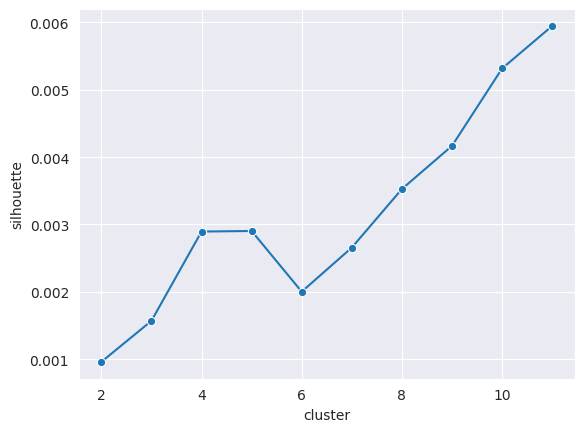

In [ ]:
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
    silhouette = silhouette_score(X_tfidf, k_means.predict(X_tfidf))
    return silhouette

silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 12):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X_tfidf))
    silhouette_res["cluster"].append(cluster_num)

silhouette_df = pd.DataFrame(silhouette_res)
sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [ ]:
# Кластеризация текста с помощью модели LDA
k = 9                                         # Опитимальное кол-во кластеров, обучается 8 минут
lda = LatentDirichletAllocation(n_components=k,
                                max_iter=200,
                                random_state=42)
lda.fit(X_tfidf)

LatentDirichletAllocation(max_iter=200, n_components=9, random_state=42)

In [ ]:
# Вывод результатов кластеризации (потенциальные темы для облаков слов)

Journal = {}
for i, text in enumerate(corpus):
  Journal[lda.transform(X_tfidf[i])[0].argmax()] = text

Journal

{4: 'екатеринбург-арена',
 6: 'владимир лишенков',
 2: 'родниковое месторождение',
 7: 'анализ защищённость',
 8: 'ивановская область',
 3: 'многофункциональный комплекс амфион',
 5: 'производители квадрокоптеров могут запустить производство в страна',
 0: 'утрата капитать',
 1: 'председатель суд'}

Выведем графики тем, которые нашла наша LDA-модель.

In [ ]:
def plot_top_words(model, feature_names, title, n_top_words=15):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

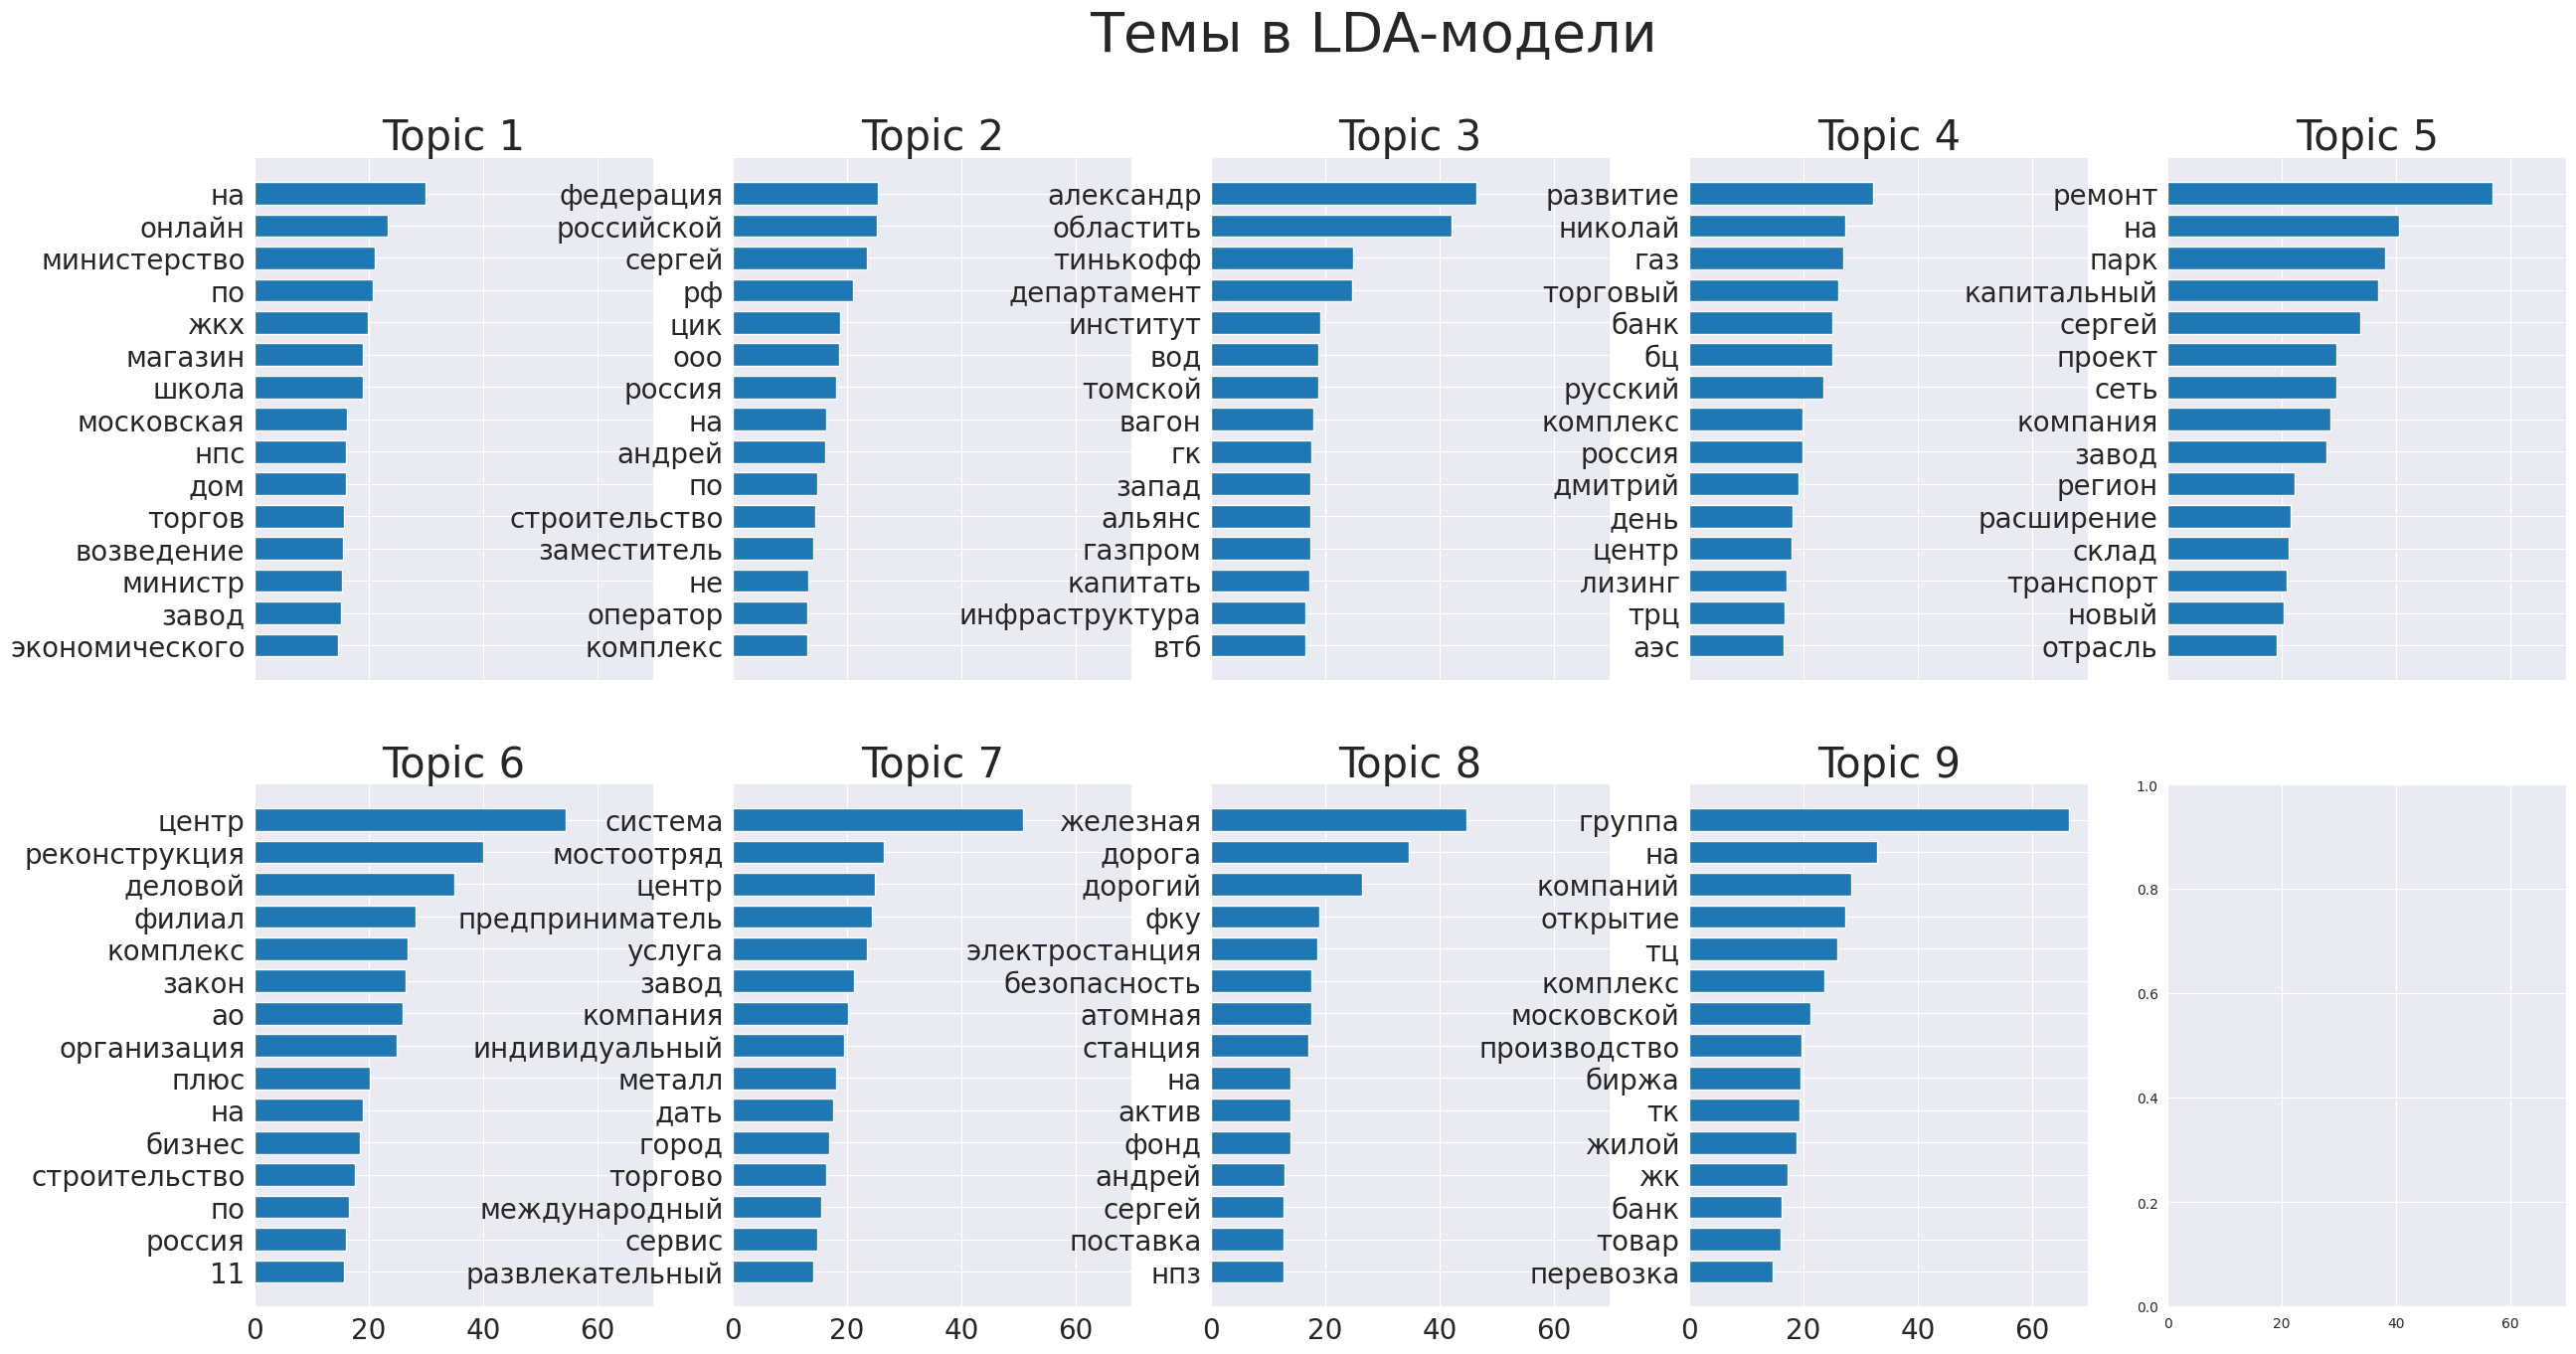

In [ ]:
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, "Темы в LDA-модели")